# Data Science with Neo4j Using Yelp Data

### Module 2: Segmentation and Community Detection (Work in Progress)

Goal: Find communities based on categories of restaurants users review      

Algorithm: Label Propagation

High Level Approach:
      
- Subset data to only include restaurants in Toronto.  Consequently, this means we are only considering users who reviewed restaurants in Toronto.
- Remove initial dependency on category taxonomy (re: Jesus' post)
- Create weights between users to form tighter communities (jaccard index between users based on # restaurant categories)
- Draw parallels with traditional data science clustering approaches (eg: k-means, kNN)

In [3]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "neo4jneo4j"))

In [10]:
%%time
# get count of businesses in each category. this will be used to determine which categories to include in our analysis
query = """
        MATCH (c:Category)
        RETURN c.name, size(()-[:IN_CATEGORY]->(c)) AS business_count   
        ORDER BY c, business_count DESC
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('business_count',ascending=False))

,business_count,c.name
7,1478,Food
2,940,Nightlife
4,907,Bars
16,629,Canadian (New)
37,619,Sandwiches
5,606,Breakfast & Brunch
14,559,Chinese
39,551,Cafes
25,509,Pizza
6,496,Coffee & Tea


CPU times: user 40.9 ms, sys: 3.07 ms, total: 44 ms
Wall time: 53.1 ms


In [ ]:
# more clean-up required once category taxonomy removed

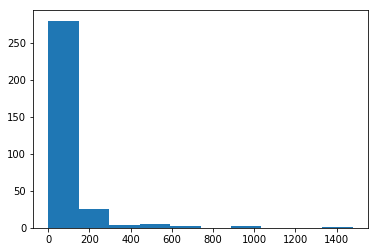

,business_count
count,321.000000
mean,59.551402
std,150.383046
min,1.000000
25%,1.000000
50%,6.000000
75%,37.000000
max,1478.000000


In [11]:
plt.hist(result_df['business_count'])
plt.show()  

result_df.describe()

In [16]:
# for now, use categories with at least 10 businesses
result_df_new = result_df[result_df['business_count'] >= 100]
display(result_df_new.sort_values('business_count',ascending=False))

,business_count,c.name
7,1478,Food
2,940,Nightlife
4,907,Bars
16,629,Canadian (New)
37,619,Sandwiches
5,606,Breakfast & Brunch
14,559,Chinese
39,551,Cafes
25,509,Pizza
6,496,Coffee & Tea


In [18]:
%%time
# find average number of categories a business can belong to, as well as min and max
query = """
        MATCH (b:Business)
        WITH size((b)-[:IN_CATEGORY]->()) AS count
        RETURN AVG(count) AS avgCat,  MIN(count) AS minCount, MAX(count) AS maxCat
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    print(row)

<Record avgCat=2.753497481813092 minCount=0 maxCat=15>
CPU times: user 2.42 ms, sys: 2.59 ms, total: 5.02 ms
Wall time: 144 ms


In [ ]:
%%time
# before running label propagation, define similarity between user pairs using Jaccard index
# this will be used as the weight for Label Propagation
# numerator: count of categories that they've reviewed together
# denominator: count of categories between the two of them
# criteria: business has to be restaurant in Toronto
# for now, keep calculation simple.  room for improvement later (ie: take into account # businesses in each category)

query = """
        // Get user pairs and count of distinct restaurant categories that they have both reviewed
        MATCH (u1:User)-[:REVIEWED]->(b1:Business)-[:IN_CATEGORY]->(c:Category),
              (u2:User)-[:REVIEWED]->(b2:Business)-[:IN_CATEGORY]->(c)
        WHERE u1 <> u2
        RETURN u1, u2, COUNT(DISTINCT c) as intersection_count  
        """
       

with driver.session() as session:
    result = session.run(query)

In [ ]:
# Get count of all the distinct categories that they have reviewed between them
MATCH (u:User)-[:REVIEWED]->(b:Business)-[:IN_CATEGORY]->(c:Category)
WHERE u in [u1, u2]
WITH u1, u2, intersection_count, COUNT(DISTINCT c) as union_count

// Compute Jaccard index and store it as relationship between u1 and u2
WITH u1, u2, intersection_count, union_count, (intersection_count*1.0/union_count) as jaccard_index
CREATE (u1)-[s:SIMILAR_TO]-(u2)
SET s.jaccard_index = jaccard_index


In [ ]:
jaccard_df = pd.DataFrame([dict(record) for record in result])

In [92]:
%%time
# incorporate weights between user pairs in order to create tighter communities
# weightProperty - Jaccard index
query = """
        CALL algo.labelPropagation(
            'MATCH (u:User)-[:REVIEWED]->(:Business) RETURN id(u) as id',   
            
            'MATCH (u1:User)-[:REVIEWED]>(b1:Business)-[:IN_CATEGORY]->(c:Category),
                   (u2:User)-[:REVIEWED]->(b2:Business)-[:IN_CATEGORY]->(c)

             RETURN DISTINCT id(u1) as source, id(u2) as target', 
             'OUTGOING',
            {graph: 'cypher', iterations:10, partitionProperty:'partition', write: true})
        YIELD nodes, iterations, loadMillis, computeMillis, writeMillis, write, partitionProperty;
        """

with driver.session() as session:
    result = session.run(query)
    
for row in result:
    print(row)

<Record nodes=6764792 iterations=10 loadMillis=29382 computeMillis=25497 writeMillis=39893 write=True partitionProperty='partition'>
CPU times: user 6.12 ms, sys: 9.46 ms, total: 15.6 ms
Wall time: 1min 34s


In [100]:
%%time
# check number of communities
query = """
        MATCH (u:User)
        RETURN count(DISTINCT u.partition)
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    print(row)

<Record count(DISTINCT u.partition)=872>
CPU times: user 2.39 ms, sys: 3.24 ms, total: 5.63 ms
Wall time: 1.99 s


In [101]:
%%time
# check number of business partitions????
query = """
        MATCH (b:Business)
        RETURN count(DISTINCT b.partition)
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    print(row)

<Record count(DISTINCT b.partition)=196>
CPU times: user 2.04 ms, sys: 3.18 ms, total: 5.23 ms
Wall time: 358 ms


In [ ]:
%%time
# remove partition
query = """
        MATCH (n:Review)
        REMOVE n.partition 
        RETURN n
        """

with driver.session() as session:
    result = session.run(query)